# Black-Litterman Sentiment Portfolio Optimizer
**Core Logic:** Blends market-cap equilibrium with FinBERT-derived news sentiment to optimize portfolios.

**Methodology:** 
1. Scrape live financial headlines from **Finviz** using BeautifulSoup.
2. Generate sentiment vectors using a pre-trained FinBERT Transformer.
3. Build a dynamic Relative Picking Matrix (P) for "Winner vs. Loser" matchups.
4. Calculate Expected Returns via Bayesian Inference (weighting views by precision).
5. Fetch historical pricing from **yfinance** to calculate the Covariance Matrix (Sigma).
6. Derive optimal weights using Markowitz Mean-Variance Optimization.
   
**Tools:** Python, NumPy (Linear Algebra), Pandas, FinBERT, BeautifulSoup, yfinance.

**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from datetime import datetime
import matplotlib.pyplot as plt

C:\Users\arnav\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Functions**

In [3]:
def get_news(ticker): 
    header = {"User-Agent" : "Mozilla/5.0"}
    url = "https://finviz.com/quote.ashx?t=" + ticker
    headlines = []

    page = requests.get(url, headers = header)
    soup = BeautifulSoup(page.content, "html.parser")
    news_table = soup.find(id = "news-table")

    if news_table is not None:
        rows = news_table.find_all("tr")
        for row in rows: 
            headline = row.a.get_text()
            headlines.append(headline)
            if len(headlines) == 100:
                break
    return headlines

In [4]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def get_sentiment(list_of_headlines): 
    if len(list_of_headlines) == 0: 
        return 0 

    encoded_input = tokenizer(list_of_headlines, padding = True, truncation = True, return_tensors = "pt")
    with torch.no_grad():
        prediction = model(**encoded_input)
    scores = torch.nn.functional.softmax(prediction.logits, dim = -1)
    scores = scores.numpy()

    total_score = 0 
    for i in range(len(scores)):
        pos_value = scores[i][0]
        neg_value = scores[i][1]
        mood = pos_value - neg_value 
        total_score = total_score + mood

    avg_mood = total_score / len(scores)
    return avg_mood

In [5]:
def get_market_cap(tickers):
    all_caps = []
    for t in tickers:
        stock = yf.Ticker(t)
        market_cap = stock.info.get('marketCap', 1)
        all_caps.append(market_cap)
    
    total_cap = sum(all_caps)
    for c in all_caps:
        market_weights = np.array(all_caps) / total_cap
    return market_weights

In [6]:
def get_P_Q_matrices(tickers, sorted_df):
    num_pairs = len(tickers) // 2  
    winners_losers_list = [] # Textbook variable: P - Links
    win_amounts_list = []    # Textbook variable: Q - Spread

    for i in range(num_pairs):
        row = np.zeros(len(tickers))
        
        high_ticker = sorted_df.iloc[i]['ticker']
        high_idx = tickers.index(high_ticker)
        low_ticker = sorted_df.iloc[-(i+1)]['ticker']
        low_idx = tickers.index(low_ticker)
        row[high_idx] = 1
        row[low_idx] = -1
        
        spread = sorted_df.iloc[i]['sentiment'] - sorted_df.iloc[-(i+1)]['sentiment']
        winners_losers_list.append(row)
        win_amounts_list.append(spread)
    P = np.array(winners_losers_list)
    Q = np.array(win_amounts_list) 
    return P, Q

**Sentiment**

In [7]:
my_stocks = ["GOOG", "NBIS", "AMD", "LLY", "NLR", "UNH", "ANET", "AMZN", "NVO", "RDDT", "MU", "META", "NFLX", "ORCL", "PATH"]
final_results = []

for stock in my_stocks:
    print("Analyzing " + stock)
    headlines = get_news(stock)

    mood_score = get_sentiment(headlines)
    data_row = {"ticker": stock,"sentiment": mood_score}
    final_results.append(data_row)

df = pd.DataFrame(final_results)
print(df.sort_values(by = "sentiment", ascending=False))

Analyzing GOOG
Analyzing NBIS
Analyzing AMD
Analyzing LLY
Analyzing NLR
Analyzing UNH
Analyzing ANET
Analyzing AMZN
Analyzing NVO
Analyzing RDDT
Analyzing MU
Analyzing META
Analyzing NFLX
Analyzing ORCL
Analyzing PATH
   ticker  sentiment
6    ANET   0.206582
2     AMD   0.204388
14   PATH   0.197474
4     NLR   0.192419
10     MU   0.184317
1    NBIS   0.179812
8     NVO   0.152831
3     LLY   0.136497
7    AMZN   0.075726
0    GOOG   0.047461
11   META  -0.032795
5     UNH  -0.046741
13   ORCL  -0.054584
12   NFLX  -0.074218
9    RDDT  -0.127241


**Historical Movement**

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf

tickers = df['ticker'].tolist()

print("Downloading historical data...")
price_data = yf.download(tickers, period="3y")['Close']

C:\Users\arnav\AppData\Local\Temp\ipykernel_23396\154968689.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, period="3y")['Close']
[*********************100%***********************]  15 of 15 completed


**Black-Litterman Prep**

In [13]:
daily_returns = price_data.pct_change().dropna()    # Returns Matrix
sigma = daily_returns.cov().values * 252         # Covariance Matrix
delta = 2.5               # Risk Aversion - 2.5 is industry standard
tau = 0.05                      # Scaling factor - 0.5 is a standard

pi = delta * (sigma @ get_market_cap(tickers)) #  Equilibrium return: pi = delta * Sigma * weights

P, Q = get_P_Q_matrices(tickers, df)
omega = np.diag(np.diag(P @ (tau * sigma) @ P.T))

In [14]:
inv_omega = np.linalg.inv(omega)
inv_tau_sigma = np.linalg.inv(tau * sigma)

# Formula: [(tau*Sigma)^-1 + P.T @ Omega^-1 @ P]^-1
term_1_inv = np.linalg.inv(inv_tau_sigma + P.T @ inv_omega @ P)

# Formula: [(tau*Sigma)^-1 @ Pi + P.T @ Omega^-1 @ Q]
term_2 = (inv_tau_sigma @ pi) + (P.T @ inv_omega @ Q)

bl_returns = term_1_inv @ term_2

# Formula: Weights = (1/delta) * Sigma^-1 * BL_Returns
bl_weights = np.linalg.inv(delta * sigma) @ bl_returns

final_weights = bl_weights / np.sum(np.abs(bl_weights))

final_report = pd.DataFrame({
    'ticker': tickers,
    'bl_return': bl_returns,          
    'optimized_weight': final_weights })

final_report = final_report.merge(df[['ticker', 'sentiment']], on='ticker', how='left')

final_report['market_weight'] = get_market_cap(tickers)
final_report['weight_shift'] = final_report['optimized_weight'] - final_report['market_weight']

final_report.to_csv("data_backups/jan_20_strategy_report.csv", index=False)
print(final_report.sort_values(by='weight_shift', ascending=False))

   ticker  bl_return  optimized_weight  sentiment  market_weight  weight_shift
14   PATH   0.133299          0.131882   0.197474   6.630597e-04      0.131219
1    NBIS   0.175942          0.069227   0.179812   2.367394e-03      0.066860
3     LLY   0.169898          0.147180   0.136497   8.049093e-02      0.066689
2     AMD   0.283489          0.084256   0.204388   3.263533e-02      0.051621
5     UNH   0.182095          0.075297  -0.046741   2.592734e-02      0.049369
4     NLR   0.042412          0.032962   0.192419   8.646750e-14      0.032962
8     NVO   0.116607          0.054993   0.152831   2.394822e-02      0.031045
6    ANET   0.249804         -0.034330   0.206582   1.413683e-02     -0.048466
10     MU   0.078771         -0.013808   0.184317   3.530282e-02     -0.049111
9    RDDT   0.153699         -0.059176  -0.127241   3.785151e-03     -0.062961
12   NFLX   0.147169         -0.049057  -0.074218   3.224239e-02     -0.081299
13   ORCL   0.134819         -0.042186  -0.054584   

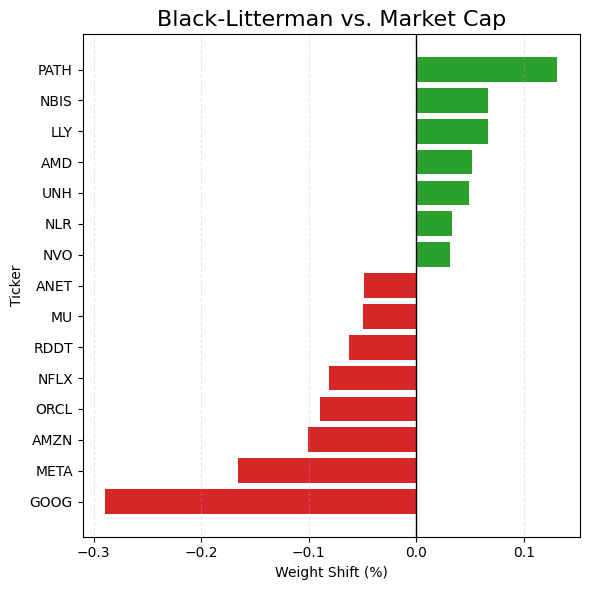

In [15]:
data = final_report.sort_values(by='weight_shift')
plt.figure(figsize=(6, 6))

colours = []
for x in data['weight_shift']:
    if x > 0:
        colours.append("#2ca02c")
    else: 
       colours.append("#d62728")

plt.barh(data['ticker'], data['weight_shift'], color=colours)
plt.title('Black-Litterman vs. Market Cap', fontsize=16)
plt.xlabel('Weight Shift (%)')
plt.ylabel('Ticker')
plt.axvline(0, color='black', linewidth=1, linestyle='-')
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('data_backups/jan_20_weight_shift_chart.png', dpi=100)